# TimeGPT

- TimeGPT es el primer modelo de base preentrenado para la previsión de series temporales que puede producir predicciones precisas en diversos dominios sin entrenamiento adicional.
- Este modelo se adapta a diferentes tamaños de entrada y horizontes de previsión gracias a su arquitectura basada en transformers.
- Está especializado en el manejo de datos de series temporales y entrenado para minimizar los errores de previsión.
- Simplifica el proceso de previsión al reducir los procesos hasta el paso de inferencia, lo que reduce la complejidad y la inversión de tiempo.


Que admite TimeGPT:
- multiple series forecasting
- agregado de variables exógenas
- evaluación con cross validations



Para mayor información:
- https://cencosud-fidelidad-rd.visualstudio.com/aa-innovation/_wiki/wikis/aa-innovation.wiki/1572/TimeGPT
- https://cencosud-fidelidad-rd.visualstudio.com/aa-innovation/_wiki/wikis/aa-innovation.wiki/1571/Foundational-Models

In [0]:
%pip install nixtla --quiet
%pip install --upgrade mlflow --quiet
dbutils.library.restartPython()

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import time
import pandas as pd
import numpy as np
import logging
import seaborn as sns
import matplotlib.pyplot as plt
# import holidays
import torch
from nixtla import NixtlaClient
from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

INFO:py4j.clientserver:Received command c on object id p0


In [0]:
from databricks.sdk.runtime import spark

INFO:py4j.clientserver:Received command c on object id p1


In [0]:
# from src.metrics.models_metrics import apply_metrics_to_groups
# from tasks.train_test_split import create_train_test_df_pandas

INFO:py4j.clientserver:Received command c on object id p1


In [0]:
# spark = SparkSession.builder.getOrCreate()
logger = spark._jvm.org.apache.log4j

# Setting the logging level to ERROR for the "py4j.java_gateway" logger
# This reduces the verbosity of the logs by only showing error messages
logging.getLogger("py4j.java_gateway").setLevel(logging.ERROR)
logging.getLogger("py4j.clientserver").setLevel(logging.ERROR)

INFO:py4j.clientserver:Received command c on object id p1


### API key as a secret

Para generar la api_key: https://dashboard.nixtla.io/sign_in

In [0]:
api_key = 'nixak-Z1q8*****************sydXUvFnjH59G'
# scope_name = "time-gpt"

nixtla_client = NixtlaClient(api_key = api_key
                            )

In [0]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

False
0


### Load your CSV data


In [0]:
# Read the CSV file
csv_df = pd.read_csv('dataset/dataset_01.csv')

# CSV file has two columns: 'unique_id' for the time series identifier and 'y' for the values
# If you have a 'date' col?umn, you can rename it to 'ds' for compatibility
csv_df = csv_df.rename(columns={"TRAN_START_DT": "ds", "QUANTITY": "y"})


In [0]:
# Prepare DataFrame
csv_df['unique_id'] = csv_df['LOCATION_ID'].astype(str) + '_' + csv_df['ITEM_ID'].astype(str) 
csv_df['ds'] = pd.to_datetime(csv_df['ds'])
csv_df = csv_df.drop(columns=['LOCATION_ID', 'ITEM_ID'])
csv_df.head()

,ds,y,unique_id
0,2022-01-02,98.0,J519_1556
1,2022-01-03,86.0,J519_1556
2,2022-01-04,77.0,J519_1556
3,2022-01-05,73.0,J519_1556
4,2022-01-06,67.0,J519_1556


In [0]:
csv_df.unique_id.nunique()

1859

In [0]:
# csv_df = csv_df.loc[csv_df.unique_id.isin(['J519_1556', 'J519_1858664001', 'J519_113752', 'J519_1883951002'])]
# csv_df = csv_df.loc[csv_df.unique_id.isin(csv_df.unique_id.unique()[:6])]

In [0]:
df = csv_df.copy()

In [0]:
df.ds.min(), df.ds.max()

(Timestamp('2022-01-02 00:00:00'), Timestamp('2024-07-31 00:00:00'))

In [0]:
# prob_discount = 0.2  # El 20% de los casos tendrá un descuento entre 0.1 y 0.5

# def generate_discounts():
#     if np.random.rand() < prob_discount:
#         return np.random.uniform(0.1, 0.5)
#     else:
#         return 0

# chile_holidays = holidays.Chile(years=[2022, 2023, 2024], language='ES')

# # Función para marcar si una fecha es feriado
# def is_holiday(date):
#     return 1 if date in chile_holidays else 0

In [0]:
# df_exog = df.copy()
# df_exog['discount'] = df_exog.apply(lambda row: generate_discounts(), axis=1).round(2)
# df_exog['is_holiday'] = df_exog['ds'].apply(is_holiday)

## Funciones

### Models

In [0]:
def predict_timegpt(df, 
                    model='timegpt-1', 
                    h=28, 
                    time_col='ds',
                    target_col='y',  
                    id_col='unique_id', 
                    level=[90], 
                    finetune_steps=None, 
                    finetune_loss=None,
                    ):
    """
    Realiza predicciones utilizando diferentes modelos de TimeGPT.
    
    Parámetros:
    - df: DataFrame con los datos de entrada.
    - model: Modelo de TimeGPT a utilizar ('timegpt-1', 'timegpt-1-long-horizon', etc.).
    - h: Horizonte de predicción.
    - time_col: Columna con las fechas.
    - target_col: Columna con los valores objetivo (y).
    - id_col: Columna con los identificadores de las series de tiempo.
    - level: Intervalos de confianza.
    - finetune_steps: Número de pasos para fine-tuning (opcional).
    - finetune_loss: Función de pérdida para el fine-tuning (opcional).

    Retorna:
    - DataFrame con las predicciones.
    """
    input_df = df.groupby('unique_id').apply(lambda group: group.iloc[0:-h]).reset_index(drop=True)
    
    extra_params = {}
    if finetune_steps is not None and finetune_loss is not None:
        extra_params['finetune_steps'] = finetune_steps
        extra_params['finetune_loss'] = finetune_loss


    start = time.time()
    fcst_df = nixtla_client.forecast(df=input_df, 
                                    h=h, 
                                    model=model, 
                                    time_col='ds',
                                    target_col='y',  
                                    id_col='unique_id',                                            
                                    level=level,
                                    **extra_params
                                    )
    end = time.time()
    duration = end - start
    print(f"Time ({model}): {duration}")
    
    fcst_df['ds'] = pd.to_datetime(fcst_df['ds'])
    return fcst_df


In [0]:
def cross_validation_timegpt(df,
                             h,
                             step_size,
                             n_windows,
                             freq='D',
                             model='timegpt-1-long-horizon',
                             time_col='ds',
                             target_col='y', 
                             id_col='unique_id',
                             finetune_steps=None, 
                             finetune_loss=None,
                             ):
    """
    Realiza la validación cruzada utilizando el modelo TimeGPT.

    Parámetros:
    - df: DataFrame con los datos de entrada.
    - model: Modelo de TimeGPT a utilizar ('timegpt-1', 'timegpt-1-long-horizon', etc.).
    - h: Horizonte de predicción.
    - step_size: Tamaño de los pasos entre ventanas de validación.
    - n_windows: Número de ventanas para la validación cruzada.
    - freq: Frecuencia temporal de los datos ('D' para diario, etc.).

    Retorna:
    - DataFrame con los resultados de la validación cruzada.
    """
    start = time.time()
    
    extra_params = {}
    if finetune_steps is not None and finetune_loss is not None:
        extra_params['finetune_steps'] = finetune_steps
        extra_params['finetune_loss'] = finetune_loss
    
    forecast_cv_df = nixtla_client.cross_validation(
        df=df,
        h=h,
        step_size=step_size,
        n_windows=n_windows,
        freq=freq,
        model=model,
        time_col='ds',
        target_col='y', 
        id_col='unique_id',
        **extra_params
    )
    end = time.time()
    duration = end - start
    print(f"Cross-validation Time ({model}): {duration}")
    
    return forecast_cv_df


In [0]:
# forecast_cv_df = nixtla_client.cross_validation(
#     df=df,
#     h=28,
#     step_size=28,
#     n_windows=12,
#     freq='D',
#     model= 'timegpt-1-long-horizon',
#     time_col='ds',
#     target_col='y', 
#     id_col='unique_id'
# )

### Metrics

In [0]:
def evaluate_metrics(test_df, fcst_df, target_col='y', model_name='TimeGPT'):
    """
    Calcula métricas como SMAPE y WMAPE para las predicciones de TimeGPT.
    
    Parámetros:
    - test_df: DataFrame con los valores reales.
    - fcst_df: DataFrame con las predicciones.
    - target_col: Columna objetivo (y).
    - model_name: Nombre del modelo a evaluar.
    
    Retorna:
    - DataFrame con las métricas calculadas.
    """
    # Unimos las predicciones con los valores reales
    results_df = pd.merge(test_df, fcst_df[['unique_id', 'ds', model_name]], 'left', ['unique_id', 'ds'])
    
    # Evaluamos SMAPE
    evaluation = evaluate(
        results_df,
        metrics=[smape],
        models=[model_name],
        target_col=target_col,
        id_col='unique_id'
    )
    
    # Calculamos la métrica promedio (por ejemplo SMAPE)
    metrics_df = evaluation.groupby(['unique_id','metric'])[model_name].mean().reset_index()
    
    return metrics_df


In [0]:
def calculate_wmape(test_df, fcst_df, target_col='y', group_col=['unique_id'], model_name='TimeGPT', metric_name='WMAPE'):
    """
    Calcula el WMAPE entre los valores reales y las predicciones.
    
    Parámetros:
    - results_df: DataFrame con los valores reales y las predicciones.
    - target_col: Columna con los valores reales.
    - model_name: Columna con las predicciones del modelo.
    
    Retorna:
    - DataFrame con la métrica WMAPE para cada serie de tiempo.
    """
    start = time.time()
    results_df = pd.merge(test_df, fcst_df, 'left', ['unique_id', 'ds'])
    def wmape(group):
        actuals = group[target_col]
        forecasts = group[model_name]
        return ((abs(actuals - forecasts).sum()) / actuals.sum()).round(3)
    
    wmape_df = results_df.groupby(group_col).apply(wmape).reset_index(name=metric_name)

    end = time.time()
    duration = end - start
    print(f"Time ({metric_name}): {duration}")

    return wmape_df


In [0]:
def calculate_cv_wmape(df, target_col='y', group_col=['unique_id'], model_name='TimeGPT', metric_name='WMAPE'):
    """
    Calcula el WMAPE entre los valores reales y las predicciones.
    
    Parámetros:
    - results_df: DataFrame con los valores reales y las predicciones.
    - target_col: Columna con los valores reales.
    - model_name: Columna con las predicciones del modelo.
    
    Retorna:
    - DataFrame con la métrica WMAPE para cada serie de tiempo.
    """
    start = time.time()
    def wmape(group):
        actuals = group[target_col]
        forecasts = group[model_name]
        return ((abs(actuals - forecasts).sum()) / actuals.sum()).round(3)
    
    wmape_df = df.groupby(group_col).apply(wmape).reset_index(name=metric_name)

    end = time.time()
    duration = end - start
    print(f"Time ({metric_name}): {duration}")

    return wmape_df


In [0]:
def calculate_wmape_grid(forecast_results, 
                         target_col='y', 
                         group_col =['unique_id','cutoff', 'model_name'], 
                         model_name='TimeGPT', 
                         metric_name='cv_wmape'):
    
    forecast_wmape = calculate_cv_wmape(forecast_results, 
                                    target_col=target_col, 
                                    group_col =group_col, 
                                    model_name=model_name, 
                                    metric_name=metric_name)
    
    cv_wmape_results = forecast_wmape.groupby(['unique_id', 'model_name']
                                              ).mean(metric_name).reset_index()
    
    cv_wmape_results = cv_wmape_results.pivot(index='unique_id', 
                                              columns='model_name', 
                                              values=metric_name)
    
    cv_wmape_results['min_wmape_model'] = cv_wmape_results.idxmin(axis=1)
    cv_wmape_results.columns = cv_wmape_results.columns.str.replace('forecast', 'wmape')

    
    return cv_wmape_results
    

## Multiple Series Forecast

TimeGPT ofrece una solución sólida para la previsión de múltiples series, que implica analizar varias series de datos simultáneamente, en lugar de una sola.

Las predicciones son univariadas. Esto significa que, aunque TimeGPT es un modelo global, no tendrá en cuenta las relaciones entre características dentro de la serie de destino. Sin embargo, TimeGPT admite el uso de variables exógenas, como variables categóricas (p. ej., categoría, marca), variables numéricas (p. ej., temperatura, precios) o incluso días festivos especiales.

In [0]:
test_df = df.groupby('unique_id').tail(28)
input_df = df.groupby('unique_id').apply(lambda group: group.iloc[0:-28]).reset_index(drop=True)

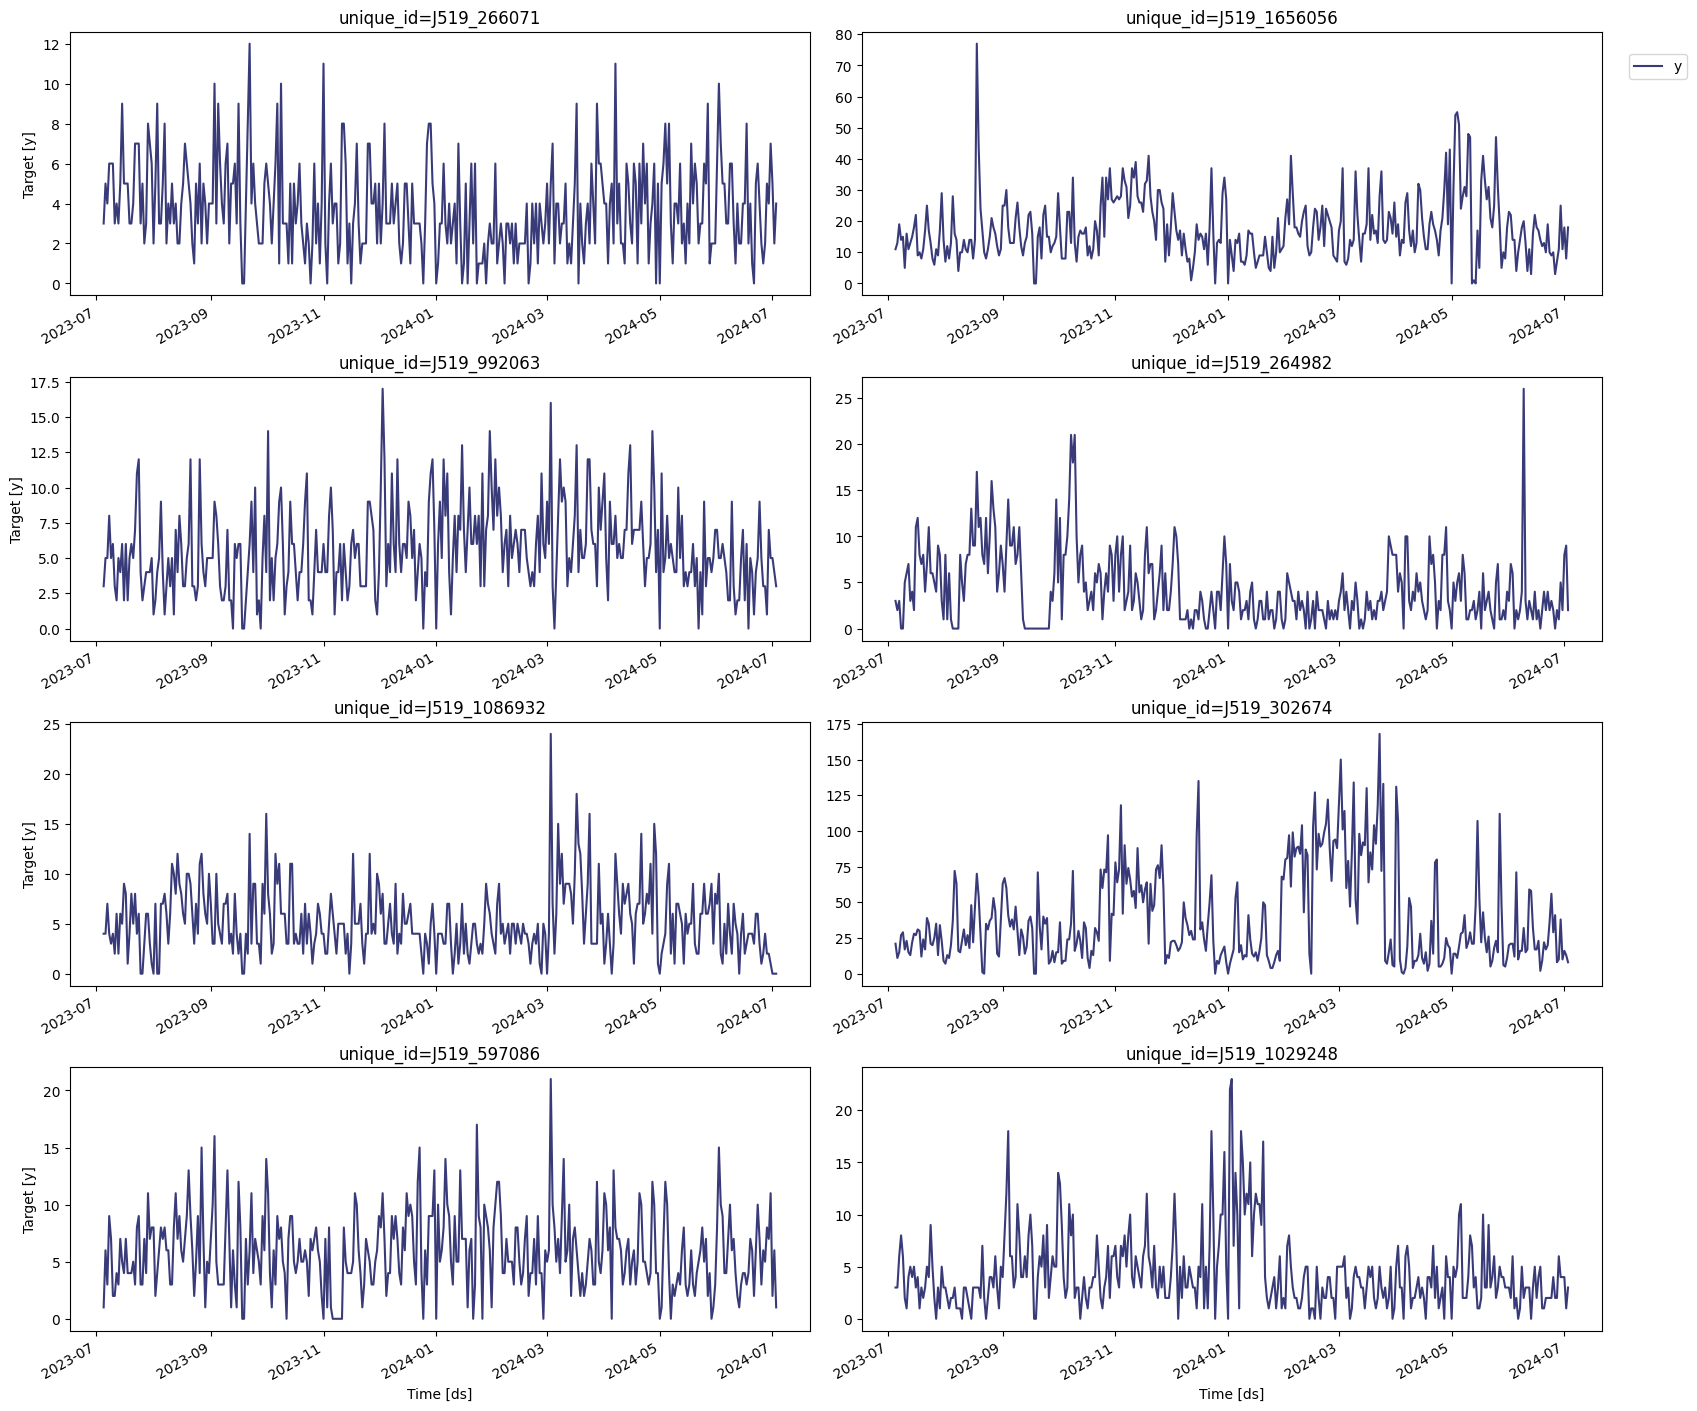

In [0]:
nixtla_client.plot(input_df,
                   max_insample_length=365,
                   )

Llamamos al método `forecast` y realizmaos las predicciones para:
- `timegpt-1` 
- `timegpt-1-long-horizon` porque estamos prediciendo 28 días
- fine tuning de cada uno de ellos de 10 steps y 'mae' loss function 


(ver de tunear esto)

Calulamos las predicciones para timegpt-1 y con fine tuning para comparar resultados

In [0]:
time_fcst_df = predict_timegpt(
  df, 
  model='timegpt-1',
  h=28,
  time_col='ds',
  target_col='y',  
  id_col='unique_id', 
  level=[90],
  )
longh_fcst_df = predict_timegpt(
  df, 
  model='timegpt-1-long-horizon',
  h=28,
  level=[90],
  time_col='ds',
  target_col='y',  
  id_col='unique_id', 
    )                     

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Time (timegpt-1): 20.920402765274048


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Time (timegpt-1-long-horizon): 25.520570755004883


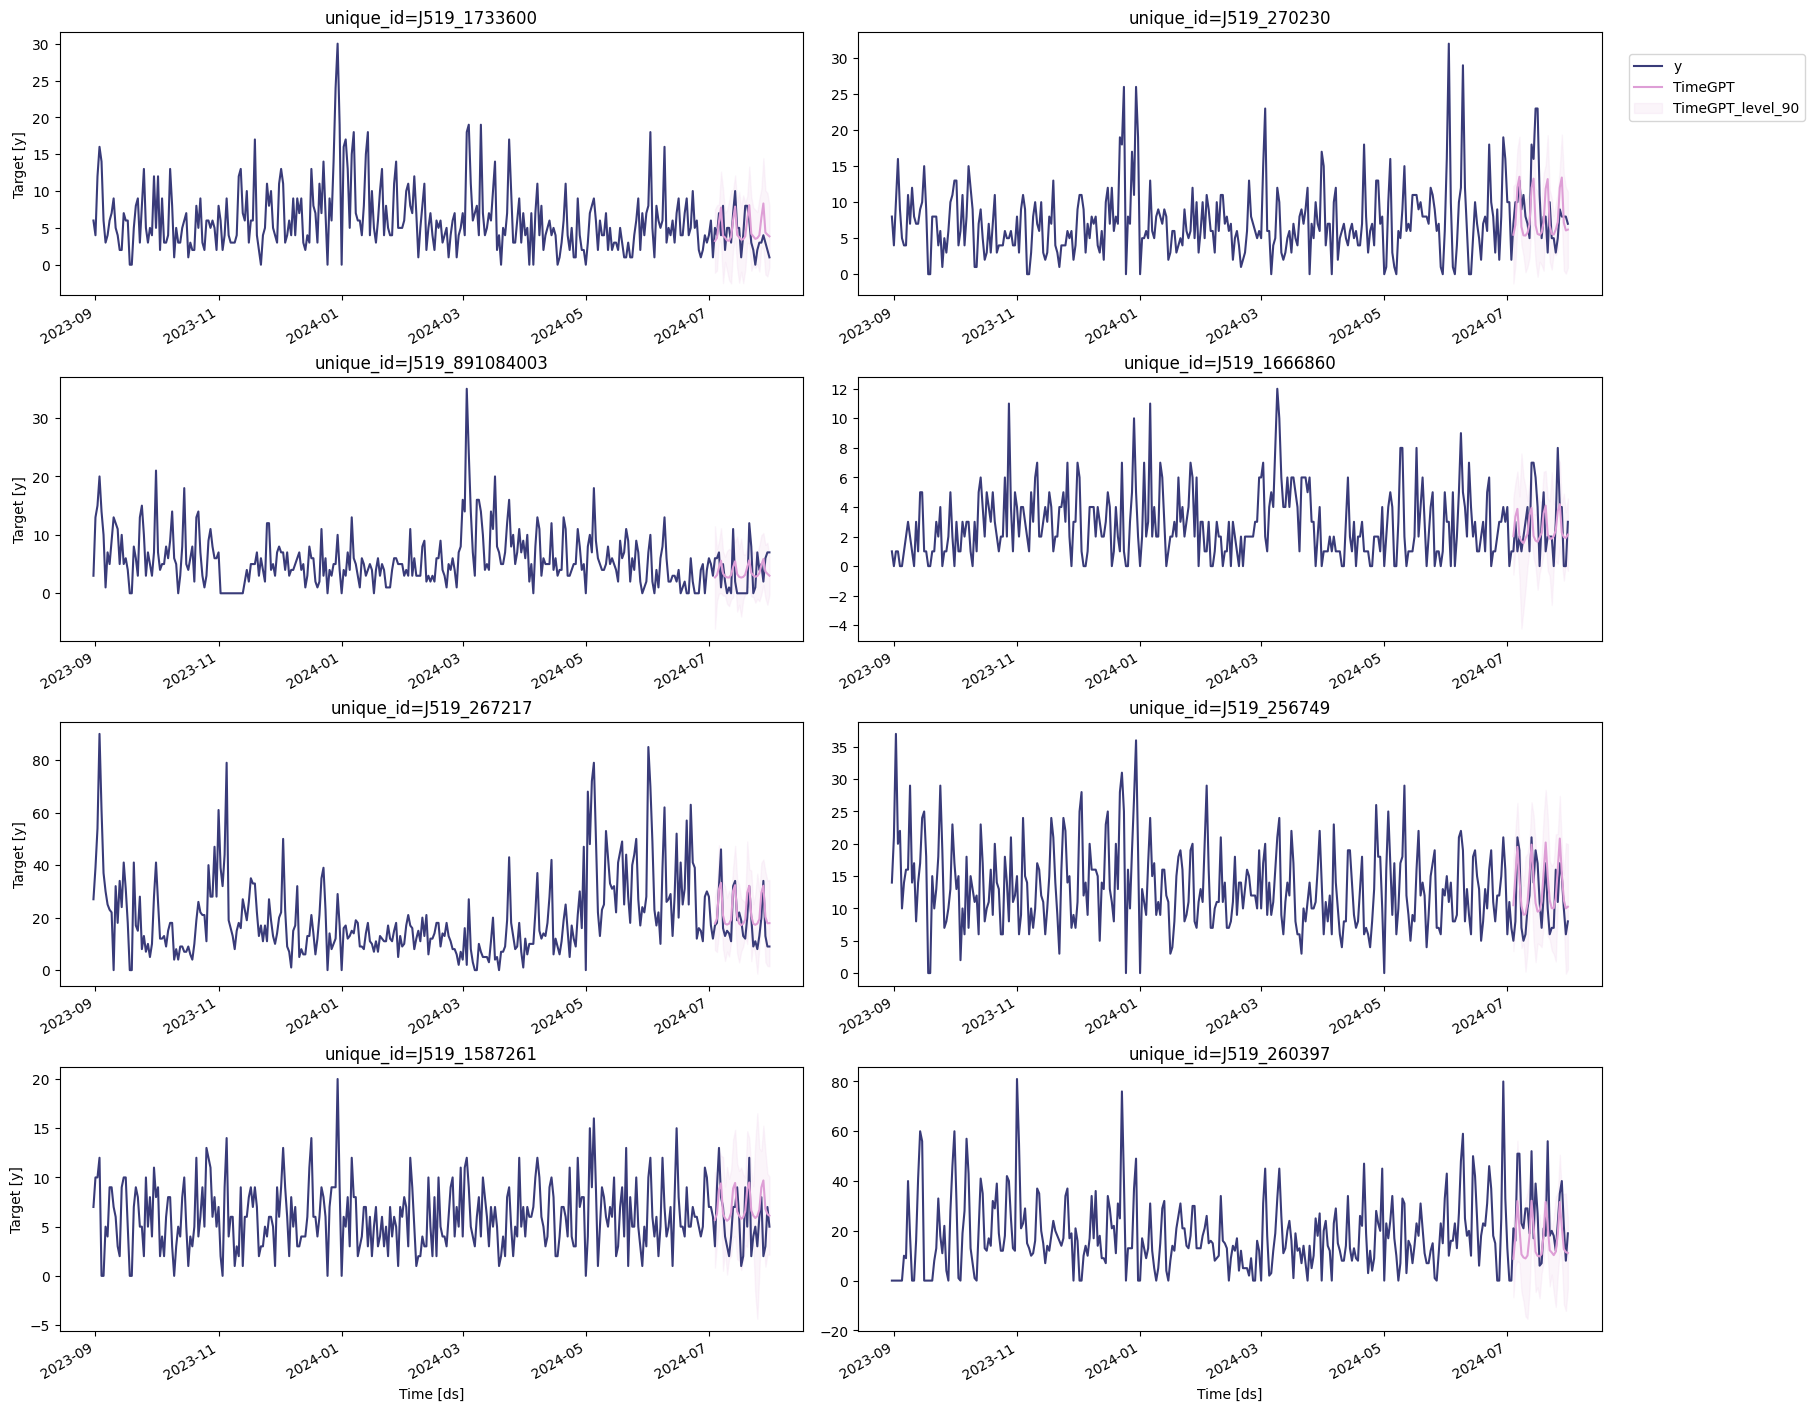

In [0]:
nixtla_client.plot(df, 
                   longh_fcst_df, 
                   models=['TimeGPT'], 
                   level=[90], 
                   time_col='ds', 
                   target_col='y',
                   max_insample_length=28*12, 
                   )

### Evaluation

In [0]:
time1_wmpae = calculate_wmape(test_df,  time_fcst_df, target_col='y', model_name='TimeGPT', metric_name='time1_wmape')
longh_wmpae = calculate_wmape(test_df,  longh_fcst_df, target_col='y', model_name='TimeGPT', metric_name='longh_wmpae')

Time (time1_wmape): 0.6720066070556641
Time (longh_wmpae): 0.6639881134033203


In [0]:
# Usar merge para realizar la unión por la columna 'unique_id'
results = time1_wmpae.merge(longh_wmpae, how='left', on='unique_id')
                            
results['min_wmape_model'] = results[['time1_wmape', 'longh_wmpae']].idxmin(axis=1)

results.head()

,unique_id,time1_wmape,longh_wmpae,min_wmape_model
0,J519_1000099,0.660,0.744,time1_wmape
1,J519_1000590,0.646,0.600,longh_wmpae
2,J519_1000929,0.697,0.640,longh_wmpae
3,J519_1004065,0.486,0.476,longh_wmpae
4,J519_1009438,0.466,0.425,longh_wmpae


In [0]:
results.min_wmape_model.value_counts()

longh_wmpae    1356
time1_wmape     503
Name: min_wmape_model, dtype: int64

In [0]:
results.describe().round(3)

,time1_wmape,longh_wmpae
count,1859.000,1859.000
mean,0.528,0.486
std,0.291,0.259
min,0.063,0.067
25%,0.364,0.340
50%,0.476,0.445
75%,0.602,0.570
max,4.387,4.549


In [0]:
results.agg(['mean', 'std']).round(3)

/root/.ipykernel/11026/command-130195163345784-2134993496:1: FutureWarning: ['unique_id', 'min_wmape_model'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  results.agg(['mean', 'std']).round(3)


,time1_wmape,longh_wmpae
mean,0.528,0.486
std,0.291,0.259


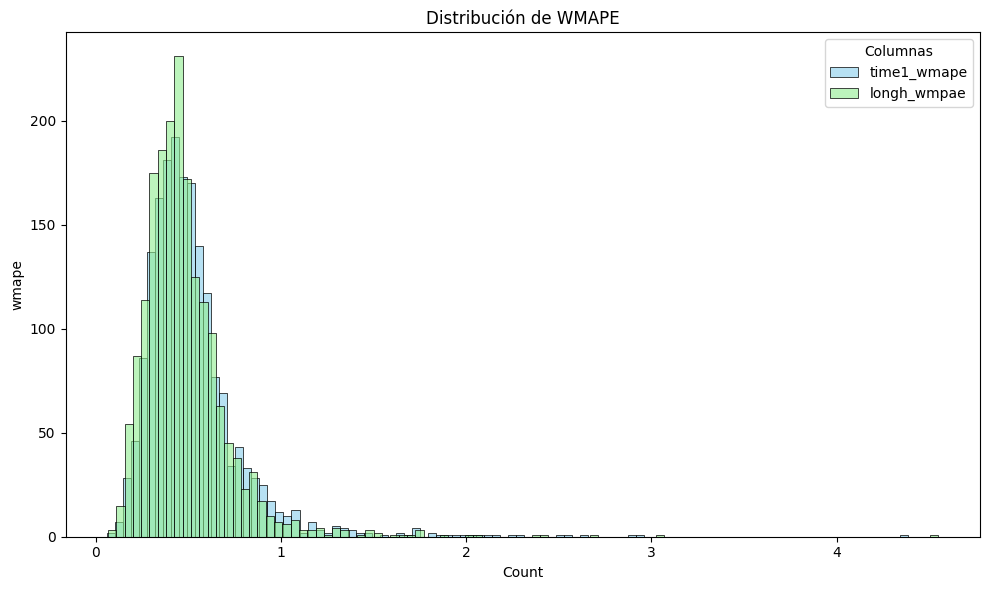

In [0]:
columns = ['time1_wmape', 'longh_wmpae']
colors = ['skyblue', 'lightgreen', 'salmon', 'gold']


plt.figure(figsize=(10, 6))

for i, col in enumerate(columns):
    sns.histplot(results[col], kde=False, bins=100, color=colors[i], label=col, alpha=0.6)

plt.title('Distribución de WMAPE')
plt.xlabel('Count')
plt.ylabel('wmape')
plt.legend(title="Columnas")


plt.tight_layout()
plt.show()


## Cross Validation

In [0]:
forecast_cv_df = cross_validation_timegpt(
    df=df,
    h=28,
    step_size=28,
    n_windows=12,
    freq='D',
    model= 'timegpt-1-long-horizon',
    time_col='ds',
    target_col='y', 
    id_col='unique_id'
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...


Cross-validation Time (timegpt-1-long-horizon): 25.536433219909668


In [0]:
forecast_cv_df.head()

,unique_id,ds,cutoff,y,TimeGPT
0,J519_1000099,2023-08-31,2023-08-30,1.0,1.750505
1,J519_1000099,2023-09-01,2023-08-30,0.0,2.426561
2,J519_1000099,2023-09-02,2023-08-30,0.0,3.465655
3,J519_1000099,2023-09-03,2023-08-30,9.0,3.727080
4,J519_1000099,2023-09-04,2023-08-30,5.0,2.325378


### Evaluation

In [0]:
wmape_df = calculate_cv_wmape(forecast_cv_df, target_col='y', group_col =['unique_id','cutoff'], model_name='TimeGPT', metric_name='cv_wmape')

Time (cv_wmape): 7.767693758010864


In [0]:
cv_results = wmape_df.groupby('unique_id').mean('cv_wmape')

In [0]:
cv_results.describe()                 

,cv_wmape
count,1859.000000
mean,0.544048
std,0.201547
min,0.098083
25%,0.433083
50%,0.525583
75%,0.624167
max,4.469333


In [0]:
cv_results.agg(['mean', 'std']).round(3)

,cv_wmape
mean,0.544
std,0.202


## Fine-tuning

### Fine-tuning metrics

In [0]:
finetune_loss = ["mae", "mse", "rmse", "mape", "smape"]
forecast_grid_results = pd.DataFrame()

for loss in finetune_loss:
    # Llama a la función de validación cruzada con la configuración actual\
    model_name = f"forecast_cv_ft_10{loss}_df"
    print(f'Running {model_name}')
    forecast_cv_df = cross_validation_timegpt(
                          df=df,
                          h=28,
                          step_size=28,
                          n_windows=12,
                          freq='D',
                          model= 'timegpt-1-long-horizon',
                          time_col='ds',
                          target_col='y', 
                          id_col='unique_id',
                          finetune_steps=10,
                          finetune_loss=loss,
                          )

    # Añade el nombre del modelo y los resultados al DataFrame
    forecast_cv_df['model_name'] = model_name
    # forecast_grid_results = forecast_grid_results.append(forecast_cv_df)
    forecast_grid_results = pd.concat([forecast_grid_results, forecast_cv_df], axis=0)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...


Running forecast_cv_ft_10mae_df


INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...


Cross-validation Time (timegpt-1-long-horizon): 36.47931408882141
Running forecast_cv_ft_10mse_df


INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...


Cross-validation Time (timegpt-1-long-horizon): 37.3348605632782
Running forecast_cv_ft_10rmse_df


INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...


Cross-validation Time (timegpt-1-long-horizon): 38.512726068496704
Running forecast_cv_ft_10mape_df


INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...


Cross-validation Time (timegpt-1-long-horizon): 36.36366248130798
Running forecast_cv_ft_10smape_df


INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...


Cross-validation Time (timegpt-1-long-horizon): 37.68301200866699


In [0]:
forecast_wmape_metrics = calculate_wmape_grid(forecast_grid_results, 
                                    target_col='y', 
                                    group_col =['unique_id', 'model_name'], 
                                    model_name='TimeGPT', 
                                    metric_name='cv_wmape')

Time (cv_wmape): 4.4164652824401855


In [0]:
forecast_wmape_metrics.describe()

model_name,wmape_cv_ft_10mae_df,wmape_cv_ft_10mape_df,wmape_cv_ft_10mse_df,wmape_cv_ft_10rmse_df,wmape_cv_ft_10smape_df
count,1859.000000,1859.000000,1859.000000,1859.000000,1859.000000
mean,0.502282,0.817506,0.508473,0.508469,0.561733
std,0.125944,0.330889,0.130715,0.130699,0.159879
min,0.096000,0.214000,0.094000,0.094000,0.138000
25%,0.416000,0.618000,0.421000,0.421000,0.463000
50%,0.502000,0.749000,0.507000,0.507000,0.555000
75%,0.587000,0.929000,0.592000,0.592000,0.648000
max,0.956000,5.630000,1.004000,0.999000,2.856000


In [0]:
forecast_wmape_metrics.iloc[:,:-1].agg(['mean', 'std']).round(3)

model_name,wmape_cv_ft_10mae_df,wmape_cv_ft_10mape_df,wmape_cv_ft_10mse_df,wmape_cv_ft_10rmse_df,wmape_cv_ft_10smape_df
mean,0.502,0.818,0.508,0.508,0.562
std,0.126,0.331,0.131,0.131,0.160


### Fine-tuneing steps

In [0]:
finetune_steps = [20, 30, 40, 50]
forecast_grid_results = pd.DataFrame()

for steps in finetune_steps:
    # Llama a la función de validación cruzada con la configuración actual
    model_name = f"forecast_cv_ft_{steps}mae_df"
    print(f'Running {model_name}')
    forecast_cv_df = cross_validation_timegpt(
                          df=df,
                          h=28,
                          step_size=28,
                          n_windows=12,
                          freq='D',
                          model= 'timegpt-1-long-horizon',
                          time_col='ds',
                          target_col='y', 
                          id_col='unique_id',
                          finetune_steps=steps,
                          finetune_loss='mae',
                          )

    # Añade el nombre del modelo y los resultados al DataFrame
    forecast_cv_df['model_name'] = model_name
    forecast_grid_results = pd.concat([forecast_grid_results, forecast_cv_df], axis=0)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...


Running forecast_cv_ft_20mae_df


INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...


Cross-validation Time (timegpt-1-long-horizon): 51.28955054283142
Running forecast_cv_ft_30mae_df


INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...


Cross-validation Time (timegpt-1-long-horizon): 54.41651797294617
Running forecast_cv_ft_40mae_df


INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...


Cross-validation Time (timegpt-1-long-horizon): 67.61337089538574
Running forecast_cv_ft_50mae_df


INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...


Cross-validation Time (timegpt-1-long-horizon): 77.26217746734619


In [0]:
forecast_wmape_steps = calculate_wmape_grid(forecast_grid_results, 
                                    target_col='y', 
                                    group_col =['unique_id','model_name'], 
                                    model_name='TimeGPT', 
                                    metric_name='cv_wmape')
forecast_wmape_steps.describe()

Time (cv_wmape): 3.329669713973999


model_name,wmape_cv_ft_20mae_df,wmape_cv_ft_30mae_df,wmape_cv_ft_40mae_df,wmape_cv_ft_50mae_df
count,1859.000000,1859.000000,1859.000000,1859.000000
mean,0.501054,0.500741,0.500149,0.499585
std,0.123554,0.122827,0.122746,0.122391
min,0.096000,0.100000,0.107000,0.110000
25%,0.416000,0.417000,0.417000,0.416000
50%,0.502000,0.502000,0.502000,0.501000
75%,0.583000,0.582500,0.582000,0.580000
max,0.935000,0.927000,0.920000,0.910000


In [0]:
forecast_wmape_steps.iloc[:,:-1].agg(['mean', 'std']).round(4)

model_name,wmape_cv_ft_20mae_df,wmape_cv_ft_30mae_df,wmape_cv_ft_40mae_df,wmape_cv_ft_50mae_df
mean,0.5011,0.5007,0.5001,0.4996
std,0.1236,0.1228,0.1227,0.1224


In [0]:
forecast_wmape_steps.min_wmape_model.value_counts()

forecast_cv_ft_50mae_df    617
forecast_cv_ft_20mae_df    582
forecast_cv_ft_40mae_df    397
forecast_cv_ft_30mae_df    263
Name: min_wmape_model, dtype: int64

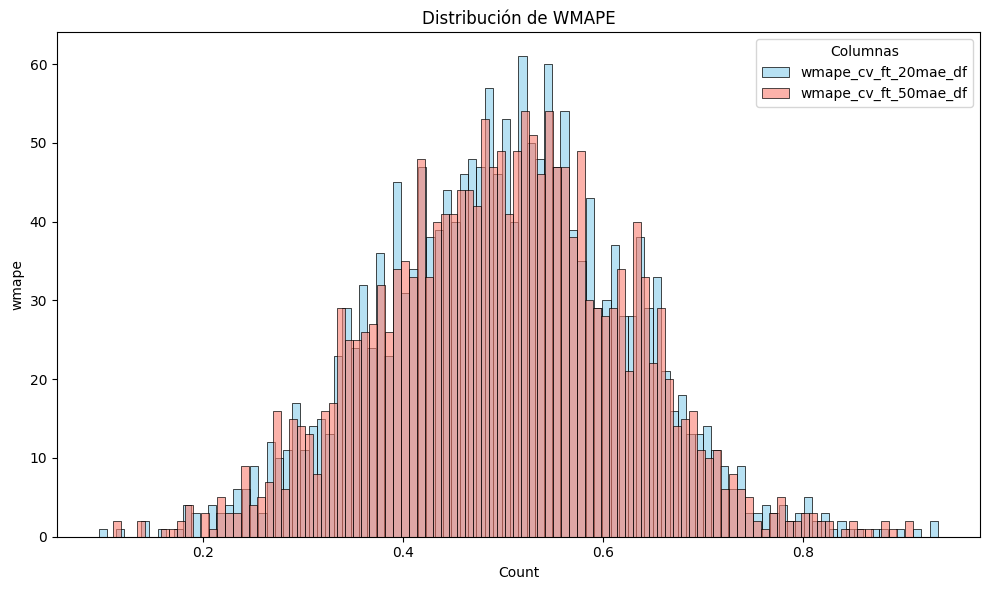

In [0]:
columns = ['wmape_cv_ft_20mae_df', 'wmape_cv_ft_50mae_df']
colors = ['skyblue', 'salmon']


plt.figure(figsize=(10, 6))

for i, col in enumerate(columns):
    sns.histplot(forecast_wmape_steps[col], kde=False, bins=100, color=colors[i], label=col, alpha=0.6)

plt.title('Distribución de WMAPE')
plt.xlabel('Count')
plt.ylabel('wmape')
plt.legend(title="Columnas")


plt.tight_layout()
plt.show()


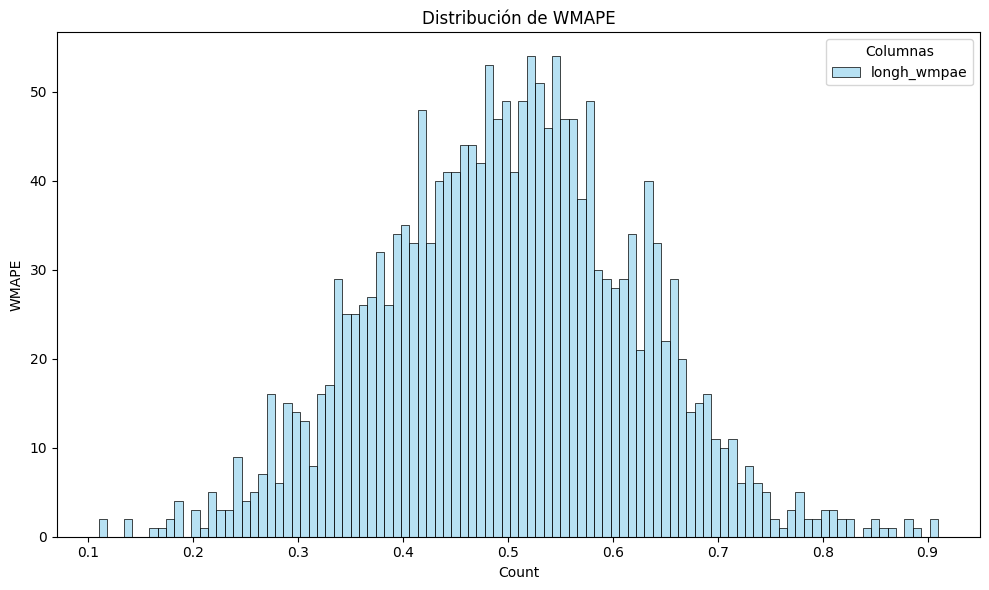

In [0]:
plt.figure(figsize=(10, 6))
sns.histplot(forecast_wmape_steps['wmape_cv_ft_50mae_df'], kde=False, bins=100, color='skyblue', label=col, alpha=0.6)

# Agregamos el título y la leyenda
plt.title('Distribución de WMAPE')
plt.xlabel('Count')
plt.ylabel('WMAPE')

# Mostramos el gráfico
plt.tight_layout()
plt.show()


## Recursos
- https://github.com/Nixtla/nixtla?tab=readme-ov-file#-quick-start
- https://docs.nixtla.io/docs/getting-started-about_timegpt
